<h1 style="text-align: left; color: #25383C;" markdown="4">Estudo bibliométrico: Formação de uma base intelectual</h1>

-- *Estudo de caso: Sensoriamento remoto aplicado à areas de conservação*
<hr />

<p style="text-align: right;"><i>Ultima atualização</i>: 5 de dezembro de 2020.<p>

<p style="text-align: justify;">Estudos bibliométricos possuem como principal objetivo identificar tendências e conexões de um campo de pesquisa em específico, com a finalidade de facilitar a identificação das pesquisas mais relevantes neste campo, quais os autores mais produtivos na área, e conhecer onde se concentra as pesquisas e os tópicos que podem ser considerados emergentes no assunto. Desta forma, a pesquisa bibliométrica constitui uma excelente ferramenta para que pesquisadores interessados em ingressar ou se atualizar sobre um determinado campo de estudo possam obter uma visão mais ampla dos seus tópicos de interesse. Para as pesquisas bibliométricas, as principais bases de dados utilizadas são a <b>Web of Science</b> e a <b>Scopus</b>. Nós iremos utilizar a base de dados <b>Scopus</b> para nosso exemplo.<p>
    
<p style="text-align: justify;">&nbsp;&nbsp;&nbsp;&nbsp;Nesse notebook utilizaremos a linguagem de programação Python para exemplificar uma pesquisa bibliométrica, tendo como campo de pesquisa <b>o uso de sensoriamento remoto aplicado ao monitoramento e avaliação de áreas de conservação no Brasil</b>. O notebook compreende a primeira parte da pesquisa, que consiste na elaboração de uma base intelectual composta de manuscritos e indicadores de publicação relevantes (número de citações, ano de publicação, revista, etc). Esta base intelectual será submetida à uma análise estatística posteriormente.<p>

<p style="text-align: justify;">&nbsp;&nbsp;&nbsp;&nbsp;O seguinte botão serve para mostrar/ocultar o código, e também deixar a página mais bonita...</p>

In [1]:
from IPython.core.display import HTML

def css_styling():
    styles = open("estilos/custom.css", "r").read()
    return HTML(styles)
css_styling()

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clique aqui para mostrar/ocultar o código Python."></form>''')

### Requisitos
<hr style=\"border:2px solid #0077b9;\">

<p style="text-align: justify;">Este notebook foi executado utilizando uma instalação Python, versão 3.7.8, com as seguintes bibliotecas (e respectivas versões):<p>
<ol>
  <li>Numpy=1.19.2</li>
  <li>Pandas=1.1.3</li>
  <li>Matplotlib=3.3.2</li>
  <li>Seaborn=0.11.0</li>
  <li>Pybliometrics=2.7.0</li>
</ol>
<p style="text-align: justify;">&nbsp;&nbsp;&nbsp;&nbsp;A rotina deve funcionar perfeitamente para versões acima  ou ligeiramente abaixo destas. Caso encontre algum problema na sua execução, entre em contato comigo pelo Twitter (<a href="https://twitter.com/ocnrviana">@ocnrviana<a>).<p>

### Etapa 1: Importação das bibliotecas
<hr />

<p style="text-align: justify;">A primeira parte do código consiste na importação das bibliotecas necessárias para a pesquisa. A principal biblioteca utilizada é a <a href="https://pybliometrics.readthedocs.io/en/stable/">pybliometrics</a>, que permite acessar e extrair informações de artigos da base de dados <b>Scopus</b>. Também serão necessárias bibliotecas para armazenar as principais informações relativas aos artigos, tais como título, ano de publicação, afiliação dos autores e etc. Para isto, iremos utilizar as bibliotecas <code>csv</code>, <code>Numpy</code> e <code>Pandas</code>. As bibliotecas <code>Matplotlib</code> e <code>Seaborn</code> serão utilizadas para uma demonstração gráfica ao final do notebook, mas não são totalmente necessárias se você não desejar realizar a visualização gráfica dos resultados da pesquisa usando Python. Finalmente, a biblioteca <code>datetime</code> será utilizada para converter os campos correspondentes ao ano de publicação do tipo <code>object</code> para <code>datetime</code>.<p>

In [2]:
"""-------------------------------------------------------------
    IMPORTAÇÃO DE BIBLIOTECAS
-------------------------------------------------------------"""
# Bibliotecas para tabelas e operações numéricas
import csv
import numpy as np
import pandas as pd

# Biblioteca OS
from datetime import datetime

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Configura o formato de exibição gráfica da biblioteca Seaborn
sns.set_context('paper')
sns.set_theme(style="whitegrid")

# Biblioteca para acessar a Base de Dados Scopus
from pybliometrics.scopus import config, AbstractRetrieval, ScopusSearch
from pybliometrics.scopus.exception import Scopus404Error, Scopus429Error

### Etapa 2: Configurando acesso a base de dados da Scopus
<hr />

<p style="text-align: justify;">A próxima etapa do código consiste em fornecer acesso ao programa à base de dados da <b>Scopus</b>. Isto é feito configurando a chave de acesso obtida na <code>API</code> da Scopus. Uma chave de acesso pode ser obtida <a href="https://dev.elsevier.com/">aqui</a>, clicando no botão <i>"I want an API Key"</i>. Após preencher um cadastro informando email e finalidade de uso, você receberá uma combinação alfa-numérica. Entre com essa combinação na variável <code>_keys</code>. Além disso, dependendo da rede em que você irá rodar o programa, apenas uma parcela das informações sobre os manuscritos estarão disponíveis. Por padrão, redes sem assinatura da <b>Scopus</b> fornecem apenas informações básicas sobre o artigo. Utilize a variável <code>api_view</code> para configurar o nível de acesso que você possui na plataforma <b>Scopus</b>.<p>

In [3]:
# Configurando a chave de acesso na API da Scopus.
_keys = ["chave de acesso aqui"]
config["Authentication"]["APIKey"] = _keys.pop()
api_view = "META"

<p style="text-align: justify;">Quando utilizando pela primeira vez o programa, é preciso que o arquivo de configuração com a chave de acesso seja criado. Após isto, não há necessidade de criar novos arquivos de configuração para realizar buscas no sistema.<p>

In [4]:
# Descomente a próxima linha para configurar a chave de acesso durante a primeira execução do programa.
# create_config()

<p style="text-align: justify;">A biblioteca <code>pybliometrics</code> fornece uma função específica para extrair as informações básicas sobre um artigo dado o seu código de identificação (EID) na <b>Scopus</b>. Para uma lista de artigos, porém, pode ser mais interessante armazenar todas essas informações em uma tabela. Desta forma, estas informações podem ser visualizadas em programas como o Excel ou OpenCalc. Para isto, utilizaremos então uma função local que, dada uma lista contendo os códigos de identificação dos artigos, são realizadas consultas recorrentes à base de dados, e as informações são então armazenadas em um <code>dataframe</code>.<p>

In [5]:
# Função para coletar informações dos artigos.
def coletar_artigos(eids_documentos, api_view):
    # Inicializa uma lista de dados vazia {data}; para cada entrada na lista de artigos obtidos
    # cria um dicionário para armazenar as informações específicas sobre o artigo e
    # armazena nessa lista
    data = []
    for key in eids_documentos:
        record = {}
        error = True
        while error:
            try:
                paper = AbstractRetrieval(key, id_type="eid", view=api_view, refresh=True)
                error = False
                # Informações básicas.
                record["id"] = paper.identifier
                record["doi"] = paper.doi
                record["eid"] = paper.eid
                record["pii"] = paper.pii
                record["pubmed_id"] = paper.pubmed_id
                record["titulo"] = paper.title
                record["resumo"] = paper.abstract
                record["descricao"] = paper.description
                record["data_publicacao"] = datetime.strptime(paper.coverDate, "%Y-%m-%d").date() \
                                            if paper.coverDate else None
                record["numero_citacao"] = paper.citedby_count
                record["idioma"] = paper.language
                record["tipo_publicacao"] = paper.aggregationType
                record["tipo_fonte"] = paper.srctype
                record["palavras_chaves"] = tuple(paper.authkeywords) if paper.authkeywords else None
                record["termos_indice"] = tuple(paper.idxterms) if paper.idxterms else None
                record["issn"] = paper.issn

                try:
                    record["isbn"] = " ".join(paper.isbn) if type(paper.isbn) == tuple else paper.isbn
                except TypeError:
                    record["isbn"] = None

                # Informações sobre a Conferencia e/ou Revista.
                record["conf_loc"] = paper.conflocation
                record["conferencia_nome"] = paper.confname
                record["revista_nome"] = paper.publicationName
                record["revista_ender"] = paper.publisheraddress
                record["titulo_ed"] = paper.issuetitle
                record["publis"] = paper.publisher

                # Informações sobre afiliação.
                record["affiliacoes"] = tuple(
                    [{"id": affil.id if affil and affil.id else None,
                      "affiliacao": affil.name if affil and affil.name else None,
                      "pais": affil.country if affil and affil.country else None}
                     for affil in paper.affiliation]) if paper.affiliation else None

                # Informações sobre os autores.
                record["autores"] = tuple(
                    [{"id": author.auid if author and author.auid else None,
                      "nome": "{} {}".format(author.given_name, author.surname) \
                            if author and author.given_name and author.surname else None}
                     for author in paper.authors]) if paper.authors else None

                record["autores_affil"] = tuple(
                    [{"id": author.auid if author and author.auid else None,
                      "nome": "{} {}".format(author.given_name, author.surname) \
                            if author and author.given_name and author.surname else None,
                      "affil_id": author.affiliation_id if author and author.affiliation_id else None,
                      "affiliacao": author.organization if author and author.organization else None,
                      "pais": author.country if author and author.country else None}
                     for author in paper.authorgroup]) if paper.authorgroup else None

                # Informações sobre referencias.
                record["ref_count"] = paper.refcount if paper.refcount else None
                record["references"] = tuple([{"id": ref.id if ref and ref.id else None,
                                            "titulo": ref.title if ref and ref.title else None,
                                            "doi": ref.doi if ref and ref.doi else None,
                                            "autores": ref.authors if ref and ref.authors else None}
                                    for ref in paper.references]) if paper.references else None

            except Scopus404Error:
                record["id"] = key
                print(key)
                error = False
            except Scopus429Error:
                # Removing the last item in _keys to assign it as new API key.
                config["Authentication"]["APIKey"] = _keys.pop()
        data.append(record)
        
    df = pd.DataFrame(data)
    
    return df

### Etapa 3: Efetuando a pesquisa à base de dados
<hr />

<p style="text-align: justify;">Uma vez configurado o ambiente para pesquisa na <code>API</code> da <b>Scopus</b>, a próxima etapa consiste na escolha dos critérios para pesquisa e consulta à base de dados. A <code>API</code> fornece vários campos de busca que podem ser consultados <a href="http://schema.elsevier.com/dtds/document/bkapi/search/SCOPUSSearchTips.htm">aqui</a>; para nosso exemplo, iremos utilizar apenas os seguintes campos:<p>

<table>
    <thead>
        <tr>
            <th style="text-align: center;">Campo</th>
            <th style="text-align: center;">Descrição</th>
        </tr>
    </thead>
    <tbody>
        <tr><td style="text-align: center;">TITLE-ABS-KEY</td>
            <td style="text-align: center;">Pesquisa no resumo, palavras-chave e título do documento se a(s) palavra(s) existe(m).</td></tr>
        <tr><td style="text-align: center;">LANGUAGE</td>
            <td style="text-align: center;">O idioma em que o documento original foi escrito.</td></tr>
        <tr><td style="text-align: center;">PUBYEAR</td>
            <td style="text-align: center;">O ano em que o documento foi publicado. Exige o uso de BEF para artigos publicados antes do ano indicado, AFT para artigos publicados após o ano indicado, ou IS para artigos publicados no ano indicado</td></tr>
    </tbody>
</table>

<p style="text-align: justify;">Para a nossa pesquisa, nós desejamos artigos que abordem o uso de sensoriamento remoto (<b>condição 1</b>) aplicado ao monitoramento e avaliação de áreas de conservação (<b>condição 2</b>) no Brasil (<b>condição 3</b>). Sendo assim, precisamos escolher as palavras-chaves na busca que representem o máximo possível dessas 3 condições. Além disso, nós limitaremos a nossa busca para artigos publicados em inglês ou português, no intervalo de tempo entre 2000 e 2020. A sentença contendo a busca deve então utilizar a seguinte forma:</p>

<blockquote><p style="text-align: center;">TITLE-ABS-KEY(condição 1)<br>AND TITLE-ABS-KEY(condição 2)<br>AND TITLE-ABS-KEY(condição 3)<br>AND PUBYEAR AFT 1999 AND PUBYEAR BEF 2021<br>AND LANGUAGE(english OR portuguese)</p></blockquote>

<p>O operador <code>AND</code> indica que todas as condições devem ser antendidas, enquanto o operador <code>OR</code> indica que pelo menos uma das condições deve ser satisfeita. Para a condição 1, foram escolhidas as palavras: "protected area" ou "conservation" ou "ecology" ou "marine protected" ou "national forest"; qualquer destas palavras (ou grupo de palavras) presente no título/resumo/palavras-chaves do artigo será considerada válida. Para a condição 2, foram escolhidas as palavras: "remote sensing" ou "earth observation" ou "Landsat" ou "Lidar" ou "MODIS" ou "Radar". Para a condição 3, foram escolhidas as palavras: "Brazil" ou "Brasil".</p>

In [6]:
# Configurando os critérios de pesquisa.
query = 'TITLE-ABS-KEY("protected area" OR "conservation" OR "ecology" OR "marine protected" OR "national forest")' \
        ' AND TITLE-ABS-KEY("remote sensing" OR "earth observation" OR "Landsat" OR "Lidar" OR "MODIS" OR "Radar")' \
        ' AND TITLE-ABS-KEY("Brazil" OR "Brasil")' \
        ' AND PUBYEAR BEF 2021 AND PUBYEAR AFT 1999' \
        ' AND LANGUAGE(english OR portuguese)'

<p style="text-align: justify;">O próximo passo consiste de realizar uma pesquisa à base de dados utilizando os critérios de busca definidos anteriormente. Para isso utilizamos a função <code>ScopusSearch</code>. Os parâmetros da função são:<p>
 <ul>
  <li>uma string contendo os dados da pesquisa, no nosso caso <code>query</code>;</li>
  <li><code>max_entries</code>, se desejamos limitar o número de resultados da pesquisa (em nosso caso <code>None</code>);</li>
     <li><code>subscriber</code>, se o acesso à <b>Scopus</b> é realizado a partir de uma rede com acesso total (<code>False</code>);</li>
  <li><code>verbose</code>, se queremos imprimir na tela uma barra de progresso do download das informações (<code>True</code>).</li>
</ul>

In [7]:
# Cria um objeto de pesquisa ScopusSearch contendo as informações para busca.
scopus = ScopusSearch(query, max_entries=None, subscriber=False, verbose=True)

# Retorna o número de registros coletados pela API.
print("Número total de publicações: {}.".format(scopus.get_results_size()))

Número total de publicações: 494.


<p style="text-align: justify;">Uma vez que a busca tenha sido executada, o próximo passo é extrair os códigos de identificação dos artigos em uma lista e utilizar a função local <code>coletar_artigos()</code> para extrair todas as informações dos artigos. <span style="color: #F62817;"><b>Atenção</b></span>: a pesquisa pode demorar alguns minutos, dependendo do número de publicações identificadas. Essas informaçãos serão armazenadas em uma tabela <code>dataframe</code> e podemos, por exemplo, visualizar os 15 artigos mais citados sobre o tema.</p>

In [8]:
# Obtêm uma lista contendo todos os identificadores digitais (EID) resgatados da API durante a busca.
eids_documentos = scopus.get_eids()

# Coleta as informações sobre os artigos, a partir dos EID e da função auxiliar.
df = coletar_artigos(eids_documentos, api_view)

# Exibe as primeiras 10 entradas contendo o título, data de publicação e DOI dos manuscritos
pd.options.display.max_colwidth = 200
df.sort_values(by='numero_citacao', ascending=False, ignore_index=True)[["titulo","data_publicacao","doi","revista_nome",'numero_citacao']].head(15).style.set_properties(**{'text-align': 'left'}).hide_index()

titulo,data_publicacao,doi,revista_nome,numero_citacao
Köppen's climate classification map for Brazil,2013-01-01,10.1127/0941-2948/2013/0507,Meteorologische Zeitschrift,3013
Ecology: Selective logging in the Brazilian Amazon,2005-10-21,10.1126/science.1118051,Science,653
Quantification of global gross forest cover loss,2010-05-11,10.1073/pnas.0912668107,Proceedings of the National Academy of Sciences of the United States of America,520
DINAMICA - A stochastic cellular automata model designed to simulate the landscape dynamics in an Amazonian colonization frontier,2002-09-01,10.1016/S0304-3800(02)00059-5,Ecological Modelling,341
Forest fragmentation and edge effects from deforestation and selective logging in the Brazilian Amazon,2008-07-01,10.1016/j.biocon.2008.04.024,Biological Conservation,285
Fire as a large-scale edge effect in Amazonian forests,2002-01-01,10.1017/S0266467402002237,Journal of Tropical Ecology,279
Mapping the world's intact forest landscapes by remote sensing,2008-01-01,10.5751/ES-02670-130251,Ecology and Society,272
Extent and conservation of tropical dry forests in the Americas,2010-01-01,10.1016/j.biocon.2009.09.020,Biological Conservation,267
Condition and fate of logged forests in the Brazilian Amazon,2006-08-22,10.1073/pnas.0604093103,Proceedings of the National Academy of Sciences of the United States of America,229
Relationships between forest stand parameters and Landsat TM spectral responses in the Brazilian Amazon Basin,2004-08-23,10.1016/j.foreco.2004.03.048,Forest Ecology and Management,220


<p style="text-align: justify;">Finalmente, utilizamos o método <code>to_csv</code> para salvar o <code>dataframe</code> em um arquivo <code>.csv</code>, que pode ser posteriormente visualizado e editado em qualquer software que trabalhe com planilhas (ou usando o próprio Python, como será visto adiante).<p>

In [9]:
# Armazena todas as entradas em um arquivo .csv, para consulta posterior
df.to_csv("data/resultado_pesquisa_scopus.csv", index=False, quoting=csv.QUOTE_ALL)

### Bônus: Visualizando o número de publicações por ano
<hr />

<p style="text-align: justify;">Esse notebook teve como objetivo apresentar um método para elaboração de uma base intelectual utilizando a linguagem de programação Python. A próxima etapa é a análise das informações adquiridas de cada artigo na base de dados <b>Scopus</b>, e será realizada em um futuro notebook.</p>
    
<p style="text-align: justify;">&nbsp;&nbsp;&nbsp;&nbsp;Para dar uma amostra prévia da utilidade de uma pesquisa bibliométrica, vamos visualizar a evolução no número de publicações em jornais especializados ao longo do período 2000-2020. A data de publicação de cada manuscrito pode ser vista na coluna <code>data_publicacao</code>. Vamos visualizar o conteúdo desta coluna:<p>

In [10]:
# Conteúdo da coluna "data_publicacao"
df["data_publicacao"]

0      2020-11-01
1      2020-11-01
2      2020-11-01
3      2020-11-01
4      2020-10-01
          ...    
489    2000-01-01
490    2000-01-01
491    2000-01-01
492    2000-01-01
493    2000-01-01
Name: data_publicacao, Length: 494, dtype: object

<p style="text-align: justify;">Como pode ser visto acima, as datas de publicação estão no formato YYYY-MM-DD, onde YYYY representa o ano, MM o mês, e DD o dia. Além disso, o tipo do dado em cada célula na coluna é <code>object</code>. Para trabalhar com a informação de data, o melhor tipo de dado em Python é o <code>datetime</code>. Iremos então converter o conteúdo do dado na tabela:</p>

In [11]:
# Converte o tipo de dado da coluna "data_publicacao" para datetime
datetimes = pd.to_datetime(df["data_publicacao"])    # realiza a conversão utilizando a função pd.to_datetime()
df["data_publicacao"] = datetimes                    # substitui o conteúdo original da coluna "data_publicacao"

# Criamos uma nova coluna para armazenar apenas o ano da publicação
df["ano_publicacao"] = df["data_publicacao"].dt.year

# Conteúdo da coluna "data_publicacao" modificado
df["data_publicacao"]

0     2020-11-01
1     2020-11-01
2     2020-11-01
3     2020-11-01
4     2020-10-01
         ...    
489   2000-01-01
490   2000-01-01
491   2000-01-01
492   2000-01-01
493   2000-01-01
Name: data_publicacao, Length: 494, dtype: datetime64[ns]

<p style="text-align: justify;">O formato da data de publicação continua o mesmo, porém o tipo do dado agora é <code>datetime</code>. Para essa visualização (e também em análises futuras), iremos utilizar apenas as publicações do tipo artigo em jornais especializados. Essas publicações são marcadas na coluna <code>tipo_publicacao</code> como <i>Journal</i>.</p>

In [12]:
# Filtra a base intelectual para conter apenas os trabalhos publicados em periódicos (categoria Journal)
tipo_publ = df["tipo_publicacao"].astype(str) == "Journal"   # O método .astype(str) converte o conteúdo da coluna em string
df = df[tipo_publ].reset_index(drop=True)

<p style="text-align: justify;">Uma vez que adicionamos a coluna <code>ano_publicacao</code>, podemos agrupar todas as publicações realizadas em um mesmo ano utilizando a função <code>groupby</code> e aplicar em seguida o método <code>size()</code> para obter a série contendo o número de publicações por ano:<p>

In [13]:
# Conta o número de publicações por ano de publicação
pub    = df.groupby("ano_publicacao").size()
# Exibe a série temporal de publicações por ano
pub

ano_publicacao
2000     1
2001     6
2002     5
2003     8
2004     7
2005     9
2006    13
2007     8
2008    15
2009     7
2010    15
2011    17
2012    23
2013    20
2014    25
2015    29
2016    30
2017    36
2018    41
2019    50
2020    42
dtype: int64

<p style="text-align: justify;">A próxima etapa é criar um novo dataframe, chamado <code>df_plot</code>, contendo apenas as informações de ano de publicação e número de publicações naquele ano. Isto é feito extraindo os valores da série <code>pub</code> e depois atribuindo a cada linha no dataframe original (em uma nova coluna, <code>Count</code>) o número total de publicações naquele ano usando o método <code>assign</code>. Finalmente, removemos todas as linhas duplicadas na coluna <code>ano_publicacao</code> e fazemos um recorte do dataframe contendo apenas as colunas <code>ano_publicacao</code> e <code>Count</code>:<p>

In [14]:
pub    = pub.values
df_pub = df.drop_duplicates(subset="ano_publicacao").assign(Count=np.flipud(pub))

# Cria uma nova tabela a partir da contagem de publicações e reorganiza por ordem crescente dos anos
df_plot = df_pub[["ano_publicacao","Count"]].copy()
df_plot = df_plot.sort_values(by=['ano_publicacao']).reset_index(drop=True)

# Exibe o novo dataframe
df_plot

,ano_publicacao,Count
0,2000,1
1,2001,6
2,2002,5
3,2003,8
4,2004,7
5,2005,9
6,2006,13
7,2007,8
8,2008,15
9,2009,7


<p style="text-align: justify;">Com o dataframe pronto, podemos então utilizar a função <code>barplot</code> da biblioteca <code>Seaborn</code> para plotar um histograma anual de publicações:<p>

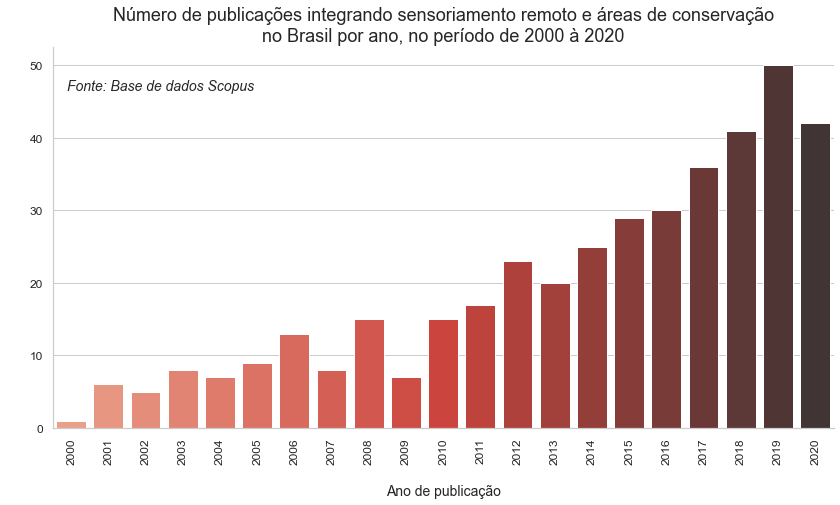

In [15]:
# Configura as fontes dos gráficos
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)         # tamanho da fonte padrão
plt.rc('axes', titlesize=SMALL_SIZE)     # tamanho da fonte do título dos eixos
plt.rc('axes', labelsize=MEDIUM_SIZE)    # tamanho da fonte dos marcadores dos eixos x e y
plt.rc('xtick', labelsize=SMALL_SIZE)    # tamanho da fonte dos marcadores do eixo-x
plt.rc('ytick', labelsize=SMALL_SIZE)    # tamanho da fonte dos marcadores do eixo-y
plt.rc('legend', fontsize=SMALL_SIZE)    # tamanho da fonte da legenda
plt.rc('figure', titlesize=BIGGER_SIZE)  # tamanho da fonte do título da figura

# Cria o plot
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(ax=ax, x="ano_publicacao", y="Count", data=df_plot, palette="Reds_d")
sns.despine(ax=ax)   # Remove os eixos da direita e superior no gráfico
plt.xticks(rotation=90)
plt.xlabel("Ano de publicação", labelpad=20)
plt.ylabel("", labelpad=10) # Remove label do eixo vertical
plt.title("Número de publicações integrando sensoriamento remoto e áreas de conservação\nno Brasil por ano, no período de 2000 à 2020", fontsize=18)
ax.annotate("Fonte: Base de dados Scopus", xy=(0.08, 0.82), size=14,  style='italic', xycoords='figure fraction')
# Descomente a linha abaixo para salvar a figura
plt.savefig('figs/total_publicacoes_ano.png', dpi=96, bbox_inches='tight', pad_inches=0.2);

<p style="text-align: justify;">É possível notar que houve um aumento exponencial no número de publicações a partir dos anos 2010-2011; este evento coincide com a liberação de dados gratuitos da série histórica do Landsat, um dos principais satélites utilizados para estudos ambientais, em Janeiro de 2008 pela NASA e USGS. Deste modo, mais instituições no país tiveram a possibilidade de efetuar estudos utilizando esses dados abertos. Em 2015, tivemos o lançamento do Sentinel-2 pela ESA, que aumentou ainda mais a gama de possibilidades de sensores a serem utilizados.<p>

## Considerações finais
<hr />

<p style="text-align: justify;">Através desse notebook nós criamos uma ferramenta para extração de informações sobre artigos contidos na base de dados <b>Scopus</b>. No próximo notebook, nós iremos utilizar essas informações para extrair informações como: Quais as tendências e o crescimento do conhecimento nessa área? Quais as principais revistas que publicam artigos na área de conservação usando sensoriamento remoto? Quais os principais sensores utilizados? Entre outras.</p>

<hr />

<p style="text-align: justify;"><small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br/><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title"><i>Estudo bibliométrico: Formação de uma base intelectual</i></span> por Rafael Viana é licenciado sobre a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>, e disponibilizado em <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/rafaeloceans/tutorials" rel="dct:source">https://github.com/rafaeloceans/tutorials</a>.</small></p>